In [3]:
import json
import pickle

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib notebook

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn import preprocessing
from sklearn.metrics import roc_auc_score, roc_curve

from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import Imputer, OneHotEncoder

import category_encoders

from lachesis.transformers import ObservationCleaner

In [4]:
def reload_dataset():
    return pd.read_csv('train.csv')

def clean_df(df):
    clean_df = df.copy()
    clean_df = clean_df.drop(['gender', 'earned dividends'], axis=1)
    clean_df['birth date'] = pd.to_datetime(clean_df['birth date']).astype(int)
    return clean_df

def encode_df(df):
    encoded_df = df.copy()
    categorical_features = (
        'job type',
        'school level',
        'domestic status',
        'profession',
        'domestic relationship type',
        'ethnicity',
        'country of origin'
    )
    for f in categorical_features:
        encoded_df[f] = encode_feature(encoded_df, f)
    return encoded_df

def encode_feature(df, feature):
    encoder = preprocessing.LabelEncoder()
    encoder.fit(df[feature].values)
    return encoder.transform(df[feature].values)


def make_train_test_datasets():
    df = reload_dataset()
    df = clean_df(df)
    df = encode_df(df)
    # Remove the target from the features
    features = df.drop(['target'], axis=1)
    # Select the target
    target = df['target']
    # Create the train/test split
    return train_test_split(features, target, test_size=0.3, random_state=0)


def optimize_and_fit(classifier, parameter_space=None, cv=5):
    X_train, X_test, y_train, y_test = make_train_test_datasets()

    if parameter_space:
        # Select grid search with cross validation
        grid_search = GridSearchCV(classifier, parameter_space, cv=cv, n_jobs=-1, scoring='roc_auc')
        grid_search.fit(X_train, y_train)
        y_pred = grid_search.predict_proba(X_test)
    else:
        classifier.fit(X_train, y_train)
        y_pred = classifier.predict_proba(X_test)

    # Score the predictions
    score = roc_auc_score(y_test, y_pred[:,1])

    print("ROC AUC: {}".format(score))
    print("Number of mislabeled points out of a total {} points: {}".format(
        y_test.shape[0], (y_test != np.round_(y_pred[:,1])).sum())
    )
    if parameter_space:
        print("Best parameters: {}".format(grid_search.best_params_))
        # print("Feature importances: {}".format(grid_search.best_estimator_.feature_importances_))
    # Data to compute the ROC curve (FPR and TPR):
    fpr, tpr, thresholds = roc_curve(y_test, y_pred[:,1])
    # The Area Under the ROC curve:
    roc_auc = roc_auc_score(y_test, y_pred[:,1])

    # Plot ROC Curve
    plt.figure(figsize=(8,6))
    lw = 2
    plt.plot(fpr, tpr, color='orange', lw=lw, label='ROC curve (AUROC = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--', label='random')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.grid()
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('{} Receiver operating characteristic'.format(type(classifier).__name__))
    plt.legend(loc="lower right")
    plt.show()

    
def make_train_test_datasets():
    df = reload_dataset()
    df = clean_df(df)
    df = encode_df(df)
    # Remove the target from the features
    features = df.drop(['target'], axis=1)
    # Select the target
    target = df['target']
    # Create the train/test split
    return train_test_split(features, target, test_size=0.3, random_state=0)


def make_optimized_pipeline():
    df = reload_dataset()

    features = df.drop(['target'], axis=1)
    target = df['target']

    X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.3, random_state=0)

    pipeline = make_pipeline(
        ObservationCleaner(),
        category_encoders.OneHotEncoder(handle_unknown='ignore'),
        Imputer(strategy='mean'),
        GridSearchCV(
            RandomForestClassifier(),
            param_grid=[{
                'max_depth': range(1, 10),
                'max_features': range(1, 10),
                'n_estimators': range(1, 10)
            }],
            cv=5,
            n_jobs=-1,
            scoring='roc_auc'
        ),
    )
    
    pipeline.fit(X_train, y_train)
      
    with open('columns.json', 'w') as fh:
        json.dump(X_train.columns.tolist(), fh)
    
    with open('pipeline.pickle', 'wb') as fh:
        from sklearn.externals import joblib
        pickle.dump(pipeline, fh)
    
    with open('dtypes.pickle', 'wb') as fh:
        pickle.dump(X_train.dtypes, fh)
        
    y_pred = pipeline.predict_proba(X_test)

    # Score the predictions
    score = roc_auc_score(y_test, y_pred[:,1])

    print("ROC AUC: {}".format(score))
    print("Number of mislabeled points out of a total {} points: {}".format(
        y_test.shape[0], (y_test != np.round_(y_pred[:,1])).sum())
    )

    # Data to compute the ROC curve (FPR and TPR):
    fpr, tpr, thresholds = roc_curve(y_test, y_pred[:,1])
    # The Area Under the ROC curve:
    roc_auc = roc_auc_score(y_test, y_pred[:,1])

    # Plot ROC Curve
    plt.figure(figsize=(8,6))
    lw = 2
    plt.plot(fpr, tpr, color='orange', lw=lw, label='ROC curve (AUROC = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--', label='random')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.grid()
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('{} Receiver operating characteristic'.format(type(pipeline).__name__))
    plt.legend(loc="lower right")
    plt.show()


ROC AUC: 0.8941615940897977
Number of mislabeled points out of a total 2450 points: 190


<IPython.core.display.Javascript object>


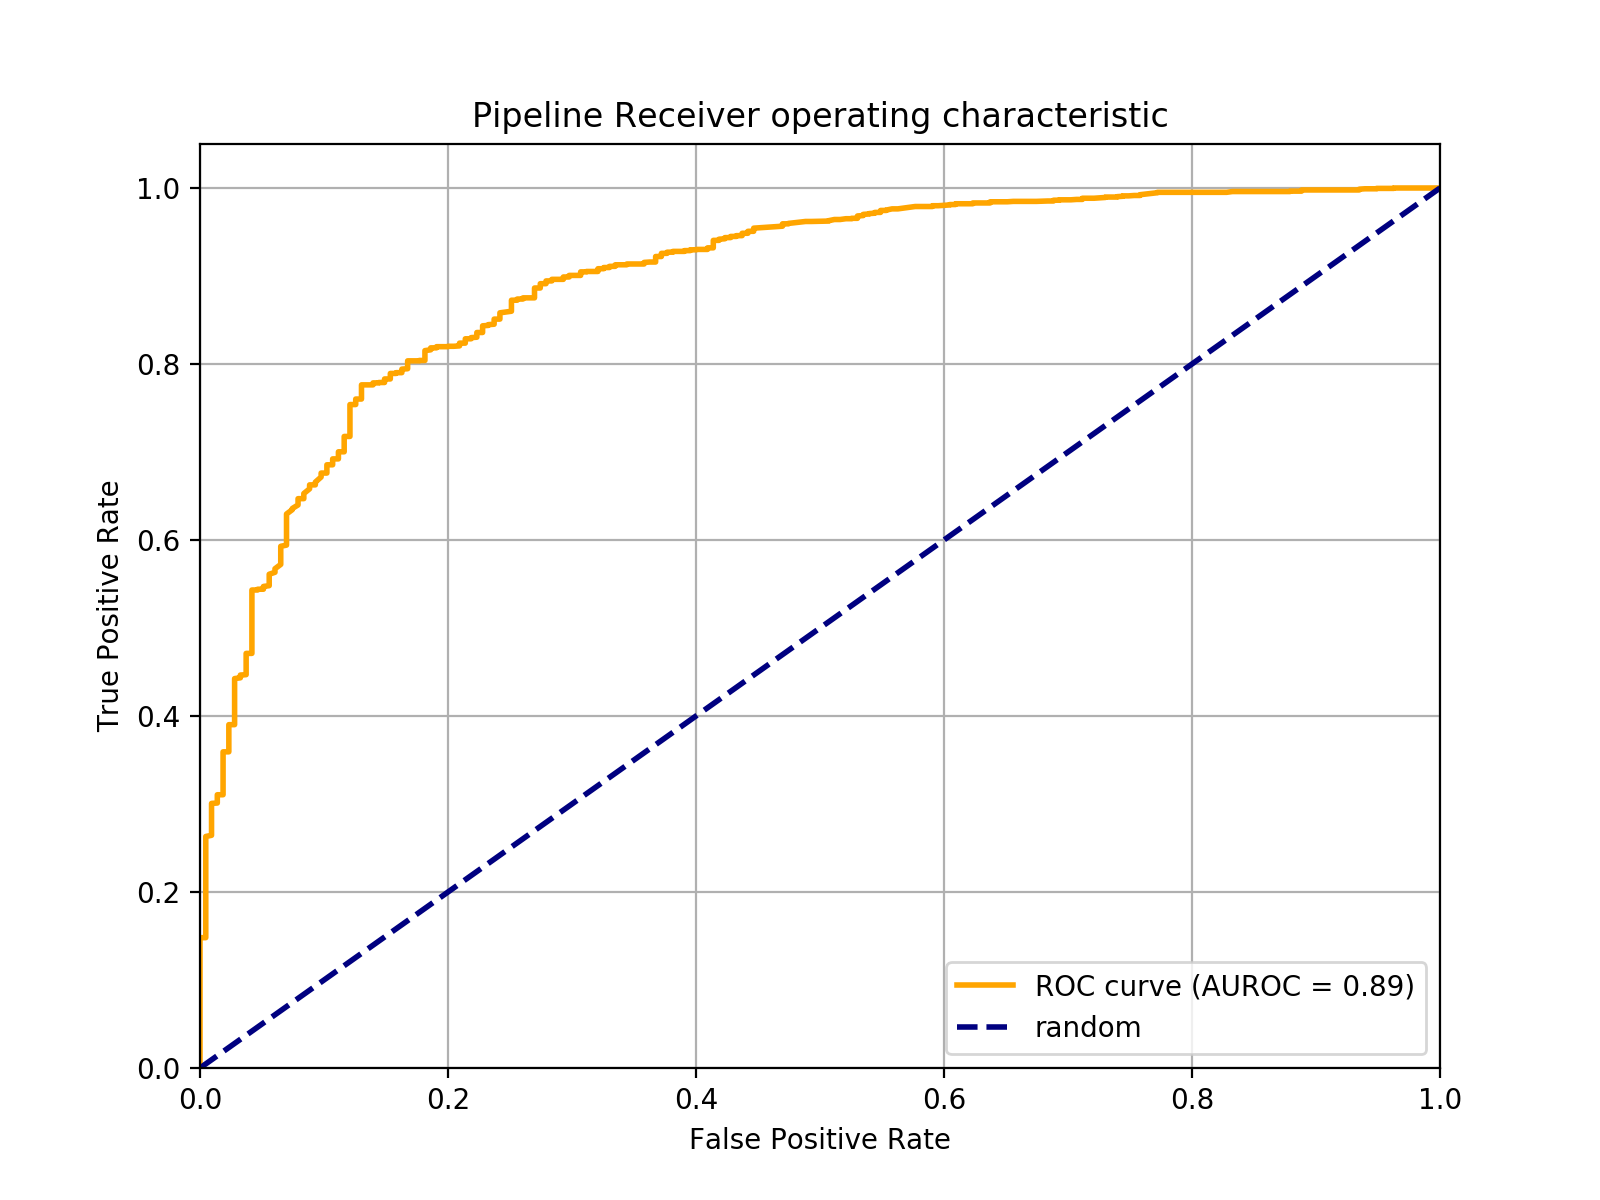

In [5]:
make_optimized_pipeline()